# Data Loading

In [1]:
import pandas as pd
import numpy as np
import os

home = os.path.expanduser("../transfermarkt-datasets") 
os.chdir(home)

from transfermarkt_datasets.core.dataset import Dataset

td = Dataset()
td.load_assets()

appearances = td.assets["cur_appearances"].prep_df
club_games = td.assets["cur_club_games"].prep_df
clubs = td.assets["cur_clubs"].prep_df
competitions = td.assets["cur_competitions"].prep_df
game_events = td.assets["cur_game_events"].prep_df
game_lineups = td.assets["cur_game_lineups"].prep_df
games = td.assets["cur_games"].prep_df
player_valuations = td.assets["cur_player_valuations"].prep_df
players = td.assets["cur_players"].prep_df

# Generated Dataset
games_filtered = pd.read_csv('../Data/games_filtered.csv')

In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
game_events

,game_event_id,date,game_id,player_id,club_id,type,minute,description,player_in_id,player_assist_id
0,2f41da30c471492e7d4a984951671677,2012-08-05,2211607,4425,610,Cards,77,"1. Yellow card , Mass confrontation",NaN,NaN
1,a72f7186d132775f234d3e2f7bc0ed5b,2012-08-05,2211607,33210,383,Cards,77,"1. Yellow card , Mass confrontation",NaN,NaN
2,b2d721eaed4692a5c59a92323689ef18,2012-08-05,2211607,36500,383,Goals,3,", Header, 1. Tournament Goal Assist: , Corner,...",NaN,56416.0
3,aef768899cedac0c9a650980219075a2,2012-08-05,2211607,36500,383,Goals,53,", Right-footed shot, 2. Tournament Goal Assist...",NaN,146258.0
4,5d6d9533023057b6619ecd145a038bbe,2012-08-05,2211607,36500,383,Substitutions,74,", Not reported",49499.0,NaN
...,...,...,...,...,...,...,...,...,...,...
693784,dcc7758976db5371e11b52564e6f146d,2024-02-27,4285670,559335,133,Substitutions,103,", Tactical",1149884.0,NaN
693785,97ab2383371614e71ac2f6d4111004d0,2024-02-27,4285670,587333,133,Cards,120,"2. Yellow card , Foul",NaN,NaN
693786,28766ee128336736420a406f2abe3ea2,2024-02-27,4285670,666526,133,Substitutions,110,", Tactical",45543.0,NaN
693787,5cf1b10b418480cf78af511a2234b968,2024-02-27,4285670,766807,133,Cards,110,"1. Yellow card , Foul",NaN,NaN


# Feature Extraction

#### Calculations baseed on the events in the game

In [4]:
"""
Calculations based on the events in the game...
- Total Conceded / Goals scored
- Total Cumulative Points
- Recent Results
"""

# Retrieve games from Premier League
games_league = games[games['competition_id'] == 'GB1'].sort_values(['season', 'round'])

# Re-format round value from "1. Matchday" to 1
games_league['round'] = games_league.apply(lambda x: int(x['round'].split('.')[0]) if x['round'] else 0, axis=1)

# Set new values for cumulative goals scored / condeded & points
games_goals = pd.DataFrame(games_league.groupby(['season', 'round', 'home_club_id', 'away_club_id'])[['home_club_goals', 'away_club_goals']].sum()).sort_values(['season', 'round']).reset_index()
games_goals['home_club_cum_goals'], games_goals['away_club_cum_goals'], games_goals['home_club_cum_concede'], games_goals['away_club_cum_concede'], games_goals['home_total_point'], games_goals['away_total_point'], games_goals['home_recent_result'], games_goals['away_recent_result'] = 0, 0, 0, 0, 0, 0, 0, 0

In [5]:
# season and team values in each list

season_team_dict = list(dict(games_goals.groupby('season')['home_club_id'].value_counts()).keys())

In [6]:
# Calculating Cumulative Sum

tmp_df = pd.DataFrame(columns=games_goals.columns)

def cumulative_sum(season, team_id, games_goals):
    tmp_df = games_goals[(games_goals['season'] == season) & ((games_goals['home_club_id'] == team_id) | (games_goals['away_club_id'] == team_id))]
    
    for i in range(1, len(tmp_df)):
        # Previous game = home, current game = home
        if (tmp_df.iloc[i-1, 2] == team_id) & (tmp_df.iloc[i, 2] == team_id):
            # Cumulative Goals
            tmp_df.iloc[i, 6] = tmp_df.iloc[i-1, 6] + tmp_df.iloc[i-1, 4]
            tmp_df.iloc[i, 8] = tmp_df.iloc[i-1, 8] + tmp_df.iloc[i-1, 5]

            # home win
            if tmp_df.iloc[i-1, 4] > tmp_df.iloc[i-1, 5]:
                tmp_df.iloc[i, 10] = tmp_df.iloc[i-1, 10] + 3
            # draw
            elif tmp_df.iloc[i-1, 4] == tmp_df.iloc[i-1, 5]:
                tmp_df.iloc[i, 10] = tmp_df.iloc[i-1, 10] + 1
            # lose
            else:
                tmp_df.iloc[i, 10] = tmp_df.iloc[i-1, 10]

        # previous game = home, current game = away
        elif (tmp_df.iloc[i-1, 2] == team_id) & (tmp_df.iloc[i, 3] == team_id):
            # Cumulative Goals
            tmp_df.iloc[i, 7] = tmp_df.iloc[i-1, 6] + tmp_df.iloc[i-1, 4]
            tmp_df.iloc[i, 9] = tmp_df.iloc[i-1, 5] + tmp_df.iloc[i-1, 8]

            # home team win
            if tmp_df.iloc[i-1, 4] > tmp_df.iloc[i-1, 5]:
                tmp_df.iloc[i, 11] = tmp_df.iloc[i-1, 10] + 3
            # draw
            elif tmp_df.iloc[i-1, 4] == tmp_df.iloc[i-1, 5]:
                tmp_df.iloc[i, 11] = tmp_df.iloc[i-1, 10] + 1
            # lose
            else:
                tmp_df.iloc[i, 11] = tmp_df.iloc[i-1, 10]

        # previous game = away, current game = home
        elif (tmp_df.iloc[i-1, 3] == team_id) & (tmp_df.iloc[i, 2] == team_id):
            # Cumulative Goals
            tmp_df.iloc[i, 6] = tmp_df.iloc[i-1, 5] + tmp_df.iloc[i-1, 7]
            tmp_df.iloc[i, 8] = tmp_df.iloc[i-1, 4] + tmp_df.iloc[i-1, 9]

            # away team win
            if tmp_df.iloc[i-1, 5] > tmp_df.iloc[i-1, 4]:
                tmp_df.iloc[i, 10] = tmp_df.iloc[i-1, 11] + 3
            # draw
            elif tmp_df.iloc[i-1, 5] == tmp_df.iloc[i-1, 4]:
                tmp_df.iloc[i, 10] = tmp_df.iloc[i-1, 11] + 1
            # lose
            else:
                tmp_df.iloc[i, 10] = tmp_df.iloc[i-1, 11]

        # previous game = away, current game = away
        else:
            # Cumulative Goals
            tmp_df.iloc[i, 7] = tmp_df.iloc[i-1, 5] + tmp_df.iloc[i-1, 7]
            tmp_df.iloc[i, 9] = tmp_df.iloc[i-1, 4] + tmp_df.iloc[i-1, 9]
            
            # away team win
            if tmp_df.iloc[i-1, 5] > tmp_df.iloc[i-1, 4]:
                tmp_df.iloc[i, 11] = tmp_df.iloc[i-1, 11] + 3
            # draw
            elif tmp_df.iloc[i-1, 5] == tmp_df.iloc[i-1, 4]:
                tmp_df.iloc[i, 11] = tmp_df.iloc[i-1, 11] + 1
            # lose
            else:
                tmp_df.iloc[i, 11] = tmp_df.iloc[i-1, 11]

    return tmp_df

# Execute the code for each season / each team
for i in range(len(season_team_dict)):
    tmp_df = pd.concat([tmp_df, cumulative_sum(season_team_dict[i][0], season_team_dict[i][1], games_goals)])

# The opponent would have the value of 0 / team of interest would have the calculated value
team_goals = pd.DataFrame(tmp_df.groupby(['season', 'round', 'home_club_id', 'away_club_id', 'home_club_goals', 'away_club_goals'])[['home_club_cum_goals', 'away_club_cum_goals', 'home_club_cum_concede', 'away_club_cum_concede', 'home_total_point', 'away_total_point', 'home_recent_result', 'away_recent_result']].max()).reset_index()
team_goals

,season,round,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_cum_goals,away_club_cum_goals,home_club_cum_concede,away_club_cum_concede,home_total_point,away_total_point,home_recent_result,away_recent_result
0,2012,1,11,289,0,0,0,0,0,0,0,0,0,0
1,2012,1,29,985,1,0,0,0,0,0,0,0,0,0
2,2012,1,281,180,3,2,0,0,0,0,0,0,0,0
3,2012,1,379,405,1,0,0,0,0,0,0,0,0,0
4,2012,1,762,148,2,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4443,2023,27,762,543,3,0,54,40,45,40,37,38,0,0
4444,2023,27,931,1237,3,0,36,49,42,41,32,39,0,0
4445,2023,27,1031,405,2,3,35,56,51,35,20,52,0,0
4446,2023,27,1132,989,0,2,25,33,58,47,13,28,0,0


In [7]:
tmp_df = pd.DataFrame(columns=team_goals.columns)

def recent_five_games(season, team_id, games_goals):
    tmp_df = games_goals[(games_goals['season'] == season) & ((games_goals['home_club_id'] == team_id) | (games_goals['away_club_id'] == team_id))]

    for i in range(0, 5):
        # current game = home
        if (tmp_df.iloc[i, 2] == team_id):
            tmp_df.iloc[i, 12] = tmp_df.iloc[i, 10]
        else:
            tmp_df.iloc[i, 13] = tmp_df.iloc[i, 11]

    for i in range(5, len(tmp_df)):
        # 5 Previous game = home, current game = home
        if (tmp_df.iloc[i-5, 2] == team_id) & (tmp_df.iloc[i, 2] == team_id):
            tmp_df.iloc[i, 12] = tmp_df.iloc[i, 10] - tmp_df.iloc[i-5, 10]
        # 5 previous game = home, current game = away
        elif (tmp_df.iloc[i-5, 2] == team_id) & (tmp_df.iloc[i, 3] == team_id):
            tmp_df.iloc[i, 13] = tmp_df.iloc[i, 11] - tmp_df.iloc[i-5, 10]
        # 5 previous game = away, current game = home
        elif (tmp_df.iloc[i-5, 3] == team_id) & (tmp_df.iloc[i, 2] == team_id):
            tmp_df.iloc[i, 12] = tmp_df.iloc[i, 10] - tmp_df.iloc[i-5, 11]
        # 5 previous game = away, current game = away
        else:
            tmp_df.iloc[i, 13] = tmp_df.iloc[i, 11] - tmp_df.iloc[i-5, 11]

    return tmp_df

for i in range(len(season_team_dict)):
    tmp_df = pd.concat([tmp_df, recent_five_games(season_team_dict[i][0], season_team_dict[i][1], team_goals)])

team_goals = pd.DataFrame(tmp_df.groupby(['season', 'round', 'home_club_id', 'away_club_id', 'home_club_goals', 'away_club_goals', 'home_club_cum_goals', 'away_club_cum_goals', 'home_club_cum_concede', 'away_club_cum_concede', 'home_total_point', 'away_total_point', ])[['home_recent_result', 'away_recent_result']].max()).reset_index()
team_goals

,season,round,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_cum_goals,away_club_cum_goals,home_club_cum_concede,away_club_cum_concede,home_total_point,away_total_point,home_recent_result,away_recent_result
0,2012,1,11,289,0,0,0,0,0,0,0,0,0,0
1,2012,1,29,985,1,0,0,0,0,0,0,0,0,0
2,2012,1,281,180,3,2,0,0,0,0,0,0,0,0
3,2012,1,379,405,1,0,0,0,0,0,0,0,0,0
4,2012,1,762,148,2,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4443,2023,27,762,543,3,0,54,40,45,40,37,38,8,9
4444,2023,27,931,1237,3,0,36,49,42,41,32,39,8,7
4445,2023,27,1031,405,2,3,35,56,51,35,20,52,4,9
4446,2023,27,1132,989,0,2,25,33,58,47,13,28,1,3


#### Basic Information

In [8]:
# games_filtered = pd.read_csv('../Data/games_filtered.csv', index_col=[0])
# games_filtered.sort_values('season')

In [9]:
# """
# Basic Information
# - Season
# - Round
# - Match Date

# Starting Lineup Information
# - Home 
# > Starting Lineup
# > Players Value (combined)
# > # of missing players

# - Away
# > Starting Lineup
# > Players Value (combined)
# > # of missing players

# Plan:
# > Inner join game_lineups + player_valuations on id and matching date
# """

# Total Player Value - Table Creation
import datetime

# Total Player Value --> Considering only the starting players
games_league = games[games['competition_id'] == 'GB1']

df1 = pd.merge(left=game_lineups[(game_lineups.type == 'starting_lineup')], right=games_league[['game_id', 'date']], how='inner', on='game_id')

df2 = pd.merge(left=df1, right=player_valuations[['player_id', 'date', 'market_value_in_eur']], how='inner', on='player_id')

# Value --> Most "Recent" Value detected
df2['date_x'] = df2['date_x'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df2['date_y'] = df2['date_y'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df2['date_diff'] = df2['date_x'] - df2['date_y']

df2 = df2[(df2.date_diff > datetime.timedelta(days=0))]

# game_id, club_id, total_market_value
player_value_sum = pd.DataFrame(df2.groupby(['game_id', 'player_id']).min('date_diff')).groupby(['game_id', 'club_id'])['market_value_in_eur'].sum()

games_combined = pd.merge(games_league, player_value_sum, left_on=['game_id', 'home_club_id'], right_on=['game_id', 'club_id'], how='inner').rename(columns={'market_value_in_eur': 'home_value'})
games_combined = pd.merge(games_combined, player_value_sum, left_on=['game_id', 'away_club_id'], right_on=['game_id', 'club_id'], how='inner').rename(columns={'market_value_in_eur': 'away_value'})
games_filtered = games_combined[games_combined['competition_id'] == "GB1"][['game_id', 'season', 'round', 'date', 'home_club_id', 'away_club_id', 'home_club_goals', 'away_club_goals', 'home_club_position', 'away_club_position', 'home_club_name', 'away_club_name', 'home_club_manager_name', 'away_club_manager_name', 'home_club_formation', 'away_club_formation', 'referee', 'home_value', 'away_value']].sort_values(['season', 'round'])


games_filtered['round'] = games_filtered.apply(lambda x: int(x['round'].split('.')[0]) if x['round'] else 0, axis=1)
games_filtered

# Saving
# games_filtered.to_csv('../Data/games_filtered.csv')

,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_name,away_club_name,home_club_manager_name,away_club_manager_name,home_club_formation,away_club_formation,referee,home_value,away_value
238,2350366,2013,1,2013-08-18,631,3008,2,0,5.0,18.0,Chelsea Football Club,Hull City,José Mourinho,Steve Bruce,4-2-3-1,4-3-3 Attacking,Jonathan Moss,54900000,5250000
437,2350361,2013,1,2013-08-17,1123,29,2,2,11.0,10.0,Norwich City,Everton Football Club,Chris Hughton,Roberto Martínez,4-2-3-1,4-2-3-1,Michael Oliver,1500000,7535000
953,2350365,2013,1,2013-08-18,873,148,0,1,14.0,7.0,Crystal Palace Football Club,Tottenham Hotspur Football Club,Ian Holloway,André Villas-Boas,4-2-3-1,4-3-3 Defending,Mark Clattenburg,2725000,3100000
1339,2350367,2013,1,2013-08-19,281,762,4,0,1.0,20.0,Manchester City Football Club,Newcastle United Football Club,Manuel Pellegrini,Alan Pardew,4-4-2 double 6,4-4-2 double 6,Andre Marriner,18200000,9750000
1529,2350359,2013,1,2013-08-17,31,512,1,0,6.0,13.0,Liverpool Football Club,Stoke City,Brendan Rodgers,Mark Hughes,4-2-3-1,4-5-1 flat,Martin Atkinson,21550000,7350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,3838010,2022,9,2022-10-01,873,631,1,2,15.0,8.0,Crystal Palace Football Club,Chelsea Football Club,Patrick Vieira,Graham Potter,4-3-3 Attacking,4-3-1-2,Chris Kavanagh,10050000,11200000
2640,3838012,2022,9,2022-10-02,399,405,0,0,11.0,12.0,Leeds United,Aston Villa Football Club,Jesse Marsch,Steven Gerrard,4-2-3-1,4-3-3 Attacking,Stuart Attwell,5925000,4975000
2641,3838013,2022,9,2022-10-03,1003,703,4,0,19.0,20.0,Leicester City,Nottingham Forest Football Club,Brendan Rodgers,Steve Cooper,4-1-4-1,4-2-3-1,Robert Jones,8350000,8150000
2860,3838008,2022,9,2022-10-01,989,1148,0,0,14.0,10.0,Association Football Club Bournemouth,Brentford Football Club,Gary O'Neil,Thomas Frank,4-4-2,4-3-3 Attacking,Thomas Bramall,2000000,1375000


In [30]:
df2[(df2['game_id'] == 2331955) & (df2['club_id'] == 289) & (df2['player_id'] == 3540)]

,game_lineups_id,game_id,player_id,club_id,type,player_name,team_captain,number,position,date_x,date_y,market_value_in_eur,date_diff
0,b8c307abf5633b23143d1f1270f9ec1b,2331955,3540,289,starting_lineup,John O'Shea,1,16,Centre-Back,2013-08-24,2004-10-04,4500000,3246 days
1,b8c307abf5633b23143d1f1270f9ec1b,2331955,3540,289,starting_lineup,John O'Shea,1,16,Centre-Back,2013-08-24,2005-02-10,5000000,3117 days
2,b8c307abf5633b23143d1f1270f9ec1b,2331955,3540,289,starting_lineup,John O'Shea,1,16,Centre-Back,2013-08-24,2005-10-18,4500000,2867 days
3,b8c307abf5633b23143d1f1270f9ec1b,2331955,3540,289,starting_lineup,John O'Shea,1,16,Centre-Back,2013-08-24,2006-06-14,5000000,2628 days
4,b8c307abf5633b23143d1f1270f9ec1b,2331955,3540,289,starting_lineup,John O'Shea,1,16,Centre-Back,2013-08-24,2007-04-25,5200000,2313 days
5,b8c307abf5633b23143d1f1270f9ec1b,2331955,3540,289,starting_lineup,John O'Shea,1,16,Centre-Back,2013-08-24,2007-07-09,5000000,2238 days
6,b8c307abf5633b23143d1f1270f9ec1b,2331955,3540,289,starting_lineup,John O'Shea,1,16,Centre-Back,2013-08-24,2008-02-04,4500000,2028 days
7,b8c307abf5633b23143d1f1270f9ec1b,2331955,3540,289,starting_lineup,John O'Shea,1,16,Centre-Back,2013-08-24,2009-06-29,5500000,1517 days
8,b8c307abf5633b23143d1f1270f9ec1b,2331955,3540,289,starting_lineup,John O'Shea,1,16,Centre-Back,2013-08-24,2010-01-25,7000000,1307 days
9,b8c307abf5633b23143d1f1270f9ec1b,2331955,3540,289,starting_lineup,John O'Shea,1,16,Centre-Back,2013-08-24,2010-08-13,7000000,1107 days


In [31]:
games[games['game_id'] == 2331955]

,game_id,competition_id,competition_type,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,...,home_club_name,away_club_name,home_club_manager_name,away_club_manager_name,home_club_formation,away_club_formation,stadium,attendance,referee,url
56518,2331955,GB1,domestic_league,2013,2. Matchday,2013-08-24,180,289,1,1,...,Southampton FC,Sunderland AFC,Mauricio Pochettino,Paolo Di Canio,4-2-3-1,4-2-3-1,St Mary's Stadium,29596.0,Lee Mason,https://www.transfermarkt.co.uk/southampton-fc...


#### Pre-Match Information

In [10]:
"""
Pre-Match Information
- Previous Match Results (against each other)
"""
from collections import Counter

# Against Each Other
team_lst = list()
for i in range(len(season_team_dict)):
    team_lst.append(season_team_dict[i][1])
team_lst = list(dict(Counter(team_lst)).keys())

previous_results = games[(games['home_club_id'].isin(team_lst)) | (games['away_club_id'].isin(team_lst))][['game_id', 'season', 'date', 'home_club_id', 'away_club_id', 'home_club_goals', 'away_club_goals']].sort_values('date')
previous_results[['home_win', 'away_win', 'draw']] = 0

teams = sorted(list(set(games[games.competition_id == 'GB1']['home_club_id'].value_counts().index.to_list())))

tmp_df = pd.DataFrame(columns = previous_results.columns)
for i in range(len(teams)):
    for j in range(i, len(teams)):
        against_each_other = previous_results[((previous_results['home_club_id'] == teams[i]) & (previous_results['away_club_id'] == teams[j])) | ((previous_results['home_club_id'] == teams[j]) & (previous_results['away_club_id'] == teams[i]))]
        for k in range(1, len(against_each_other)):
            # current = home / previous = home
            if against_each_other.iloc[k, 3] == against_each_other.iloc[k-1, 3]:
                # home win
                if against_each_other.iloc[k-1, 5] > against_each_other.iloc[k-1, 6]:
                    against_each_other.iloc[k, 7] = against_each_other.iloc[k-1, 7] + 1
                    against_each_other.iloc[k, 8] = against_each_other.iloc[k-1, 8]
                    against_each_other.iloc[k, 9] = against_each_other.iloc[k-1, 9]
                # draw
                elif against_each_other.iloc[k-1, 5] == against_each_other.iloc[k-1, 6]:
                    against_each_other.iloc[k, 7] = against_each_other.iloc[k-1, 7]
                    against_each_other.iloc[k, 8] = against_each_other.iloc[k-1, 8]
                    against_each_other.iloc[k, 9] = against_each_other.iloc[k-1, 9] + 1
                # away win
                elif against_each_other.iloc[k-1, 5] < against_each_other.iloc[k-1, 6]:
                    against_each_other.iloc[k, 7] = against_each_other.iloc[k-1, 7]
                    against_each_other.iloc[k, 8] = against_each_other.iloc[k-1, 8] + 1
                    against_each_other.iloc[k, 9] = against_each_other.iloc[k-1, 9]
            # current = home / previous = away
            elif against_each_other.iloc[k, 3] != against_each_other.iloc[k-1, 3]:
                # home win
                if against_each_other.iloc[k-1, 5] > against_each_other.iloc[k-1, 6]:
                    against_each_other.iloc[k, 8] = against_each_other.iloc[k-1, 7] + 1
                    against_each_other.iloc[k, 7] = against_each_other.iloc[k-1, 8]
                    against_each_other.iloc[k, 9] = against_each_other.iloc[k-1, 9]
                # draw
                elif against_each_other.iloc[k-1, 5] == against_each_other.iloc[k-1, 6]:
                    against_each_other.iloc[k, 8] = against_each_other.iloc[k-1, 7]
                    against_each_other.iloc[k, 7] = against_each_other.iloc[k-1, 8]
                    against_each_other.iloc[k, 9] = against_each_other.iloc[k-1, 9] + 1
                # away win
                elif against_each_other.iloc[k-1, 5] < against_each_other.iloc[k-1, 6]:
                    against_each_other.iloc[k, 8] = against_each_other.iloc[k-1, 7]
                    against_each_other.iloc[k, 7] = against_each_other.iloc[k-1, 8] + 1
                    against_each_other.iloc[k, 9] = against_each_other.iloc[k-1, 9]

        tmp_df = pd.concat([tmp_df, against_each_other])

against_each_other = tmp_df
against_each_other

,game_id,season,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_win,away_win,draw
29249,2250043,2012,2012-11-28,29,11,1,1,0,0,0
40406,2225720,2012,2013-04-16,11,29,0,0,0,0,1
19469,2332046,2013,2013-12-08,11,29,1,1,0,0,2
35850,2437462,2013,2014-03-08,11,29,4,1,0,0,3
18810,2332269,2013,2014-04-06,29,11,3,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...
202,2486630,2014,2014-12-20,3008,2288,0,1,1,0,1
35963,2486777,2014,2015-04-04,2288,3008,3,1,1,1,1
15368,2698001,2016,2016-08-20,2288,3008,0,2,2,1,1
47707,2808910,2016,2017-01-07,3008,2288,2,0,2,2,1


In [11]:
# pd.concat([team_goals, games_filtered, against_each_other], join='inner')

tmp_df = pd.merge(left=games_filtered, right=against_each_other[['game_id', 'home_win', 'away_win', 'draw']], on='game_id')
tmp_df = pd.merge(left=tmp_df, right=team_goals[['season', 'round', 'home_club_id', 'away_club_id', 'home_club_cum_goals',	'away_club_cum_goals', 'home_club_cum_concede', 'away_club_cum_concede', 'home_total_point', 'away_total_point', 'home_recent_result', 'away_recent_result']], on=['season', 'round', 'home_club_id', 'away_club_id'])
combined_data = tmp_df.astype({'home_club_position':'int16', 'away_club_position':'int16'}).sort_values(['season', 'round'])
combined_data

,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,...,away_win,draw,home_club_cum_goals,away_club_cum_goals,home_club_cum_concede,away_club_cum_concede,home_total_point,away_total_point,home_recent_result,away_recent_result
0,2350366,2013,1,2013-08-18,631,3008,2,0,5,18,...,0,0,0,0,0,0,0,0,0,0
1,2350361,2013,1,2013-08-17,1123,29,2,2,11,10,...,0,1,0,0,0,0,0,0,0,0
2,2350365,2013,1,2013-08-18,873,148,0,1,14,7,...,0,0,0,0,0,0,0,0,0,0
3,2350367,2013,1,2013-08-19,281,762,4,0,1,20,...,0,0,0,0,0,0,0,0,0,0
4,2350359,2013,1,2013-08-17,31,512,1,0,6,13,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3735,3838596,2022,38,2023-05-28,631,762,1,1,12,4,...,6,1,37,67,46,32,43,70,4,8
3736,3838598,2022,38,2023-05-28,29,989,1,0,17,15,...,6,2,33,37,57,70,33,39,5,6
3737,3838594,2022,38,2023-05-28,405,1237,2,1,7,6,...,1,2,49,71,45,51,58,62,7,9
3738,3838595,2022,38,2023-05-28,1148,281,1,0,9,1,...,2,0,57,94,46,32,56,89,12,15


# Result

In [12]:
# 1 representing home win / -1 representing away win / 0 representing draw

import numpy as np

combined_data['result'] = (np.where(
    combined_data['home_club_goals'] > combined_data['away_club_goals'],
    1,
    np.where(combined_data['home_club_goals'] < combined_data['away_club_goals'], -1, 0)
))
combined_data.to_csv('../Data/combined_data.csv')
combined_data

,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,...,draw,home_club_cum_goals,away_club_cum_goals,home_club_cum_concede,away_club_cum_concede,home_total_point,away_total_point,home_recent_result,away_recent_result,result
0,2350366,2013,1,2013-08-18,631,3008,2,0,5,18,...,0,0,0,0,0,0,0,0,0,1
1,2350361,2013,1,2013-08-17,1123,29,2,2,11,10,...,1,0,0,0,0,0,0,0,0,0
2,2350365,2013,1,2013-08-18,873,148,0,1,14,7,...,0,0,0,0,0,0,0,0,0,-1
3,2350367,2013,1,2013-08-19,281,762,4,0,1,20,...,0,0,0,0,0,0,0,0,0,1
4,2350359,2013,1,2013-08-17,31,512,1,0,6,13,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3735,3838596,2022,38,2023-05-28,631,762,1,1,12,4,...,1,37,67,46,32,43,70,4,8,0
3736,3838598,2022,38,2023-05-28,29,989,1,0,17,15,...,2,33,37,57,70,33,39,5,6,1
3737,3838594,2022,38,2023-05-28,405,1237,2,1,7,6,...,2,49,71,45,51,58,62,7,9,1
3738,3838595,2022,38,2023-05-28,1148,281,1,0,9,1,...,0,57,94,46,32,56,89,12,15,1


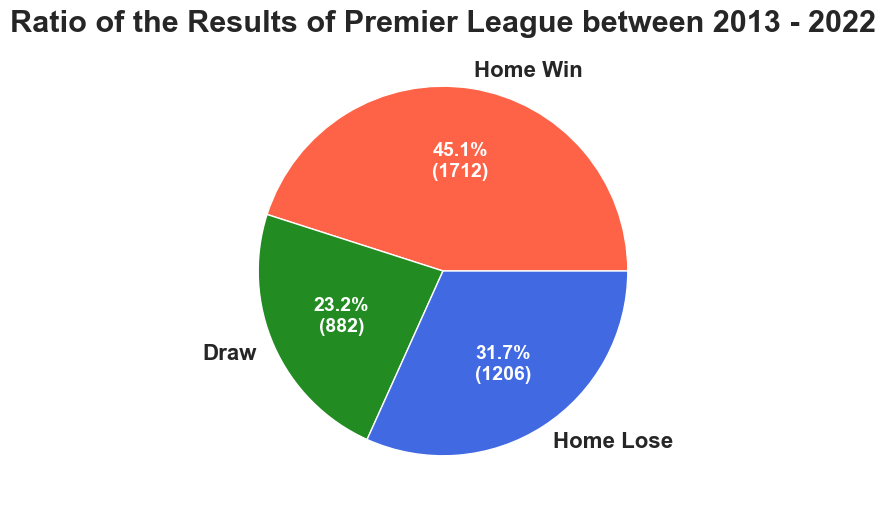

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming combined_data is defined elsewhere in your code
# Set style for chart
sns.set_style("whitegrid")

colors = ['tomato', 'forestgreen', 'royalblue']

# Create pie chart
plt.figure(figsize=(6,6))
data = pd.DataFrame(combined_data.groupby('result')['game_id'].count().sort_index(ascending=False))

# Custom formatting function to display both percentage and total count
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format

# Create pie chart with custom autopct and textprops
pie = plt.pie(data['game_id'], labels=['Home Win', 'Draw', 'Home Lose'], autopct=autopct_format(data['game_id']), colors=colors, textprops={'fontsize': 16, 'weight': 'bold'})

# Set the font size and color for the autopct (percentage values)
plt.setp(pie[2], color='white', fontsize=14)

# Add title and display chart
plt.title('Ratio of the Results of Premier League between 2013 - 2022', fontsize=22, weight='bold')

plt.show()

In [14]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Z-test for proportion of home win / draw / away win for ten years of premier league games
counts = combined_data['result'].value_counts().values # Counts for each category (-1, 0, 1)
nobs = combined_data['result'].value_counts().sum() # Total number of observations

# Perform Z-test for each category
for i in range(len(counts)):
    stat, pval = proportions_ztest(counts[i], nobs, value=1/3) # Assuming equal proportions
    print(f"Category {i+1}: Z statistic = {stat}, p-value = {pval}")

Category 1: Z statistic = 14.519774593806284, p-value = 9.08083524450885e-48
Category 2: Z statistic = -2.114381215492123, p-value = 0.03448272073210391
Category 3: Z statistic = -14.780850217236404, p-value = 1.9469289065062034e-49


# Miscalleneous

In [15]:
# Referees

list(set(games[games.competition_id == 'GB1']['referee'].value_counts().index.to_list()))

['Jarred Gillett',
 'Rebecca Welch',
 'Darren England',
 'Darren Bond',
 'Stuart Attwell',
 'Michael Salisbury',
 'Mark Halsey',
 'Anthony Taylor',
 'David Coote',
 'Samuel Barrott',
 'Josh Smith',
 'Peter Bankes',
 'Howard Webb',
 'Tony Harrington',
 'Jonathan Moss',
 'Neil Swarbrick',
 'Graham Scott',
 'Phil Dowd',
 'Craig Pawson',
 'Kevin Friend',
 'Thomas Bramall',
 'Mike Jones',
 'Mark Clattenburg',
 'Andrew Madley',
 'John Brooks',
 'Tim Robinson',
 'Samuel Allison',
 'Mike Dean',
 'Robert Jones',
 'Keith Stroud',
 'Lee Mason',
 'Paul Tierney',
 'Simon Hooper',
 'Lee Probert',
 'Roger East',
 'Chris Foy',
 'Chris Kavanagh',
 'Bobby Madley',
 'Michael Oliver',
 'Martin Atkinson',
 'Lewis Smith',
 'Andre Marriner']

In [16]:
# Teams

sorted(list(set(games[games.competition_id == 'GB1']['home_club_id'].value_counts().index.to_list())))

[11,
 29,
 31,
 148,
 180,
 281,
 289,
 350,
 379,
 399,
 405,
 512,
 543,
 603,
 631,
 641,
 703,
 762,
 873,
 931,
 984,
 985,
 989,
 1003,
 1010,
 1031,
 1032,
 1039,
 1071,
 1110,
 1123,
 1132,
 1148,
 1237,
 2288,
 3008]

In [17]:
"""
Club --> only the latest information provided by the downloaded file
Question: How to retrieve the data for around 10 years?? --> Impossible
"""

clubs[clubs['domestic_competition_id'] == "GB1"]

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,url,filename,last_season
4,148,tottenham-hotspur,Tottenham Hotspur Football Club,GB1,NaN,26,25.4,20,76.9,21,Tottenham Hotspur Stadium,62850,€-151.40m,NaN,https://www.transfermarkt.co.uk/tottenham-hots...,../data/raw/transfermarkt-scraper/2023/clubs.j...,2023
23,603,cardiff-city,Cardiff City,GB1,NaN,28,25.5,24,85.7,8,Cardiff City Stadium,33280,€-655k,NaN,https://www.transfermarkt.co.uk/cardiff-city/s...,../data/raw/transfermarkt-scraper/2018/clubs.j...,2018
30,989,afc-bournemouth,Association Football Club Bournemouth,GB1,NaN,26,25.8,17,65.4,12,Vitality Stadium,11329,€-125.79m,NaN,https://www.transfermarkt.co.uk/afc-bournemout...,../data/raw/transfermarkt-scraper/2023/clubs.j...,2023
42,3008,hull-city,Hull City,GB1,NaN,28,25.0,17,60.7,6,MKM Stadium,25586,+€7.50m,NaN,https://www.transfermarkt.co.uk/hull-city/star...,../data/raw/transfermarkt-scraper/2016/clubs.j...,2016
43,31,fc-liverpool,Liverpool Football Club,GB1,NaN,28,25.6,21,75.0,17,Anfield,54074,€-111.30m,NaN,https://www.transfermarkt.co.uk/fc-liverpool/s...,../data/raw/transfermarkt-scraper/2023/clubs.j...,2023
59,1010,fc-watford,Watford FC,GB1,NaN,30,26.3,24,80.0,12,Vicarage Road,21577,+€42.02m,NaN,https://www.transfermarkt.co.uk/fc-watford/sta...,../data/raw/transfermarkt-scraper/2021/clubs.j...,2021
85,1003,leicester-city,Leicester City,GB1,NaN,25,27.1,14,56.0,11,King Power Stadium,32273,+€26.00m,NaN,https://www.transfermarkt.co.uk/leicester-city...,../data/raw/transfermarkt-scraper/2022/clubs.j...,2022
86,1237,brighton-amp-hove-albion,Brighton and Hove Albion Football Club,GB1,NaN,27,25.4,19,70.4,14,AMEX Stadium,31800,+€86.40m,NaN,https://www.transfermarkt.co.uk/brighton-amp-h...,../data/raw/transfermarkt-scraper/2023/clubs.j...,2023
135,703,nottingham-forest,Nottingham Forest Football Club,GB1,NaN,28,26.9,24,85.7,16,The City Ground,30445,€-48.73m,NaN,https://www.transfermarkt.co.uk/nottingham-for...,../data/raw/transfermarkt-scraper/2023/clubs.j...,2023
138,1031,luton-town,Luton Town Football Club,GB1,NaN,28,27.4,15,53.6,9,Kenilworth Road,11050,€-25.92m,NaN,https://www.transfermarkt.co.uk/luton-town/sta...,../data/raw/transfermarkt-scraper/2023/clubs.j...,2023


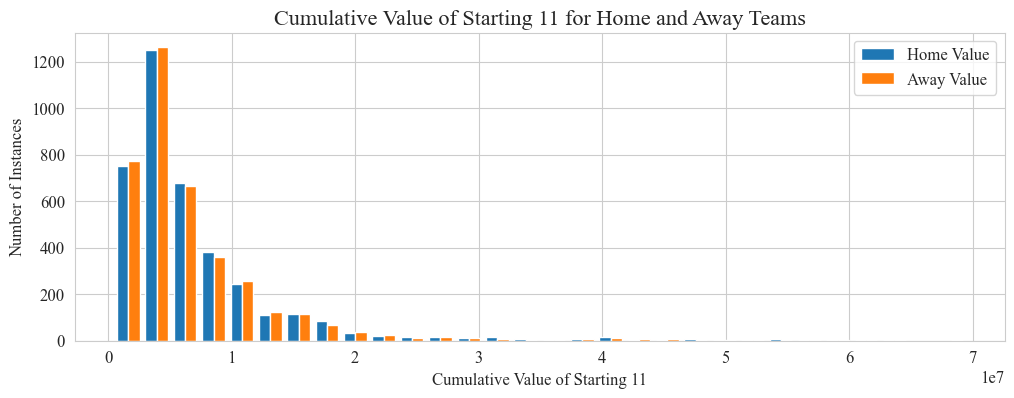

In [18]:
import matplotlib.pyplot as plt

# Set the font to Times New Roman and the font size to 22 for all text elements
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(12,4))
# Plot the histogram with labels for the legend
plt.hist((combined_data['home_value'].values, combined_data['away_value'].values), bins=30, label=['Home Value', 'Away Value'])
plt.ylabel('Number of Instances')
plt.xlabel('Cumulative Value of Starting 11')

# Set the title with a font size of 22
plt.title('Cumulative Value of Starting 11 for Home and Away Teams', fontsize=16)

# Add the legend
plt.legend(fontsize=12)
plt.show()


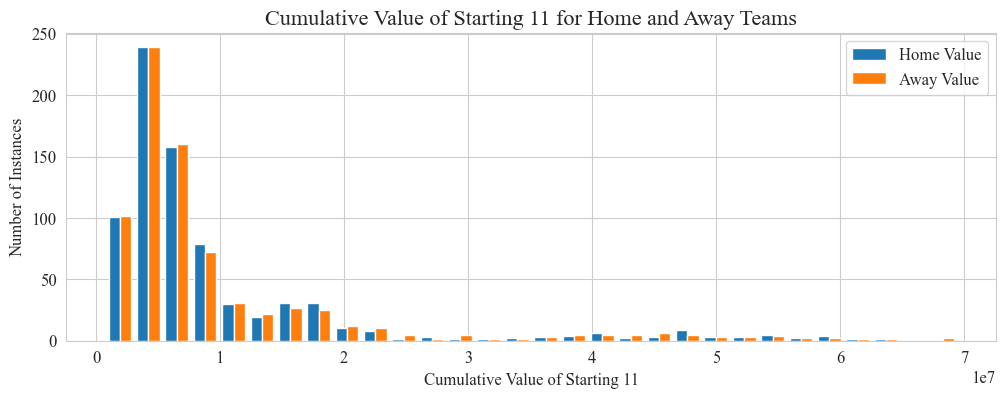

In [19]:
combined_data_filtered = combined_data[combined_data['season'] < 2015]

import matplotlib.pyplot as plt

# Set the font to Times New Roman and the font size to 22 for all text elements
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(12,4))
# Plot the histogram with labels for the legend
plt.hist((combined_data_filtered['home_value'].values, combined_data_filtered['away_value'].values), bins=30, label=['Home Value', 'Away Value'])
plt.ylabel('Number of Instances')
plt.xlabel('Cumulative Value of Starting 11')

# Set the title with a font size of 22
plt.title('Cumulative Value of Starting 11 for Home and Away Teams', fontsize=16)

# Add the legend
plt.legend(fontsize=12)
plt.show()

In [20]:
combined_data_filtered[combined_data_filtered['game_id'] == 2350366][['home_club_id', 'away_club_id', 'home_value', 'away_value']]

,home_club_id,away_club_id,home_value,away_value
0,631,3008,54900000,5250000


In [21]:
# """
# Basic Information
# - Season
# - Round
# - Match Date

# Starting Lineup Information
# - Home 
# > Starting Lineup
# > Players Value (combined)
# > # of missing players

# - Away
# > Starting Lineup
# > Players Value (combined)
# > # of missing players

# Plan:
# > Inner join game_lineups + player_valuations on id and matching date
# """

# Total Player Value - Table Creation
import datetime

# Total Player Value --> Considering only the starting players
games_league = games[games['competition_id'] == 'GB1']

df1 = pd.merge(left=game_lineups[(game_lineups.type == 'starting_lineup')], right=games_league[['game_id', 'date']], how='inner', on='game_id')

df2 = pd.merge(left=df1, right=player_valuations[['player_id', 'date', 'market_value_in_eur']], how='inner', on='player_id')

# Value --> Most "Recent" Value detected
df2['date_x'] = df2['date_x'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df2['date_y'] = df2['date_y'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df2['date_diff'] = df2['date_x'] - df2['date_y']

df2 = df2[(df2.date_diff > datetime.timedelta(days=0))]

# game_id, club_id, total_market_value
# player_value_sum = pd.DataFrame(df2.groupby(['game_id', 'player_id']).min('date_diff')).groupby(['game_id', 'club_id'])['market_value_in_eur'].sum()
player_value_sum = pd.DataFrame(df2.groupby(['game_id', 'player_id']).min('date_diff')).groupby(['game_id', 'club_id'])['market_value_in_eur']

# games_combined = pd.merge(games_league, player_value_sum, left_on=['game_id', 'home_club_id'], right_on=['game_id', 'club_id'], how='inner').rename(columns={'market_value_in_eur': 'home_value'})
# games_combined = pd.merge(games_combined, player_value_sum, left_on=['game_id', 'away_club_id'], right_on=['game_id', 'club_id'], how='inner').rename(columns={'market_value_in_eur': 'away_value'})
# games_filtered = games_combined[games_combined['competition_id'] == "GB1"][['game_id', 'season', 'round', 'date', 'home_club_id', 'away_club_id', 'home_club_goals', 'away_club_goals', 'home_club_position', 'away_club_position', 'home_club_name', 'away_club_name', 'home_club_manager_name', 'away_club_manager_name', 'home_club_formation', 'away_club_formation', 'referee', 'home_value', 'away_value']].sort_values(['season', 'round'])


# games_filtered['round'] = games_filtered.apply(lambda x: int(x['round'].split('.')[0]) if x['round'] else 0, axis=1)
# games_filtered

# Saving
# games_filtered.to_csv('../Data/games_filtered.csv')

In [22]:
# test = df2.groupby(['game_id', 'player_id']).min('date_diff')
test = df2[(df2['game_id'] == 2350365)].groupby('player_id').min('date_difference').sort_values(['club_id', 'market_value_in_eur'])
test

,game_id,club_id,team_captain,market_value_in_eur
player_id,,,,
9988,2350365,148,1,50000
59631,2350365,148,0,50000
90466,2350365,148,0,50000
95424,2350365,148,0,50000
19368,2350365,148,0,100000
43250,2350365,148,0,100000
50174,2350365,148,0,100000
17965,2350365,148,0,150000
57229,2350365,148,0,150000


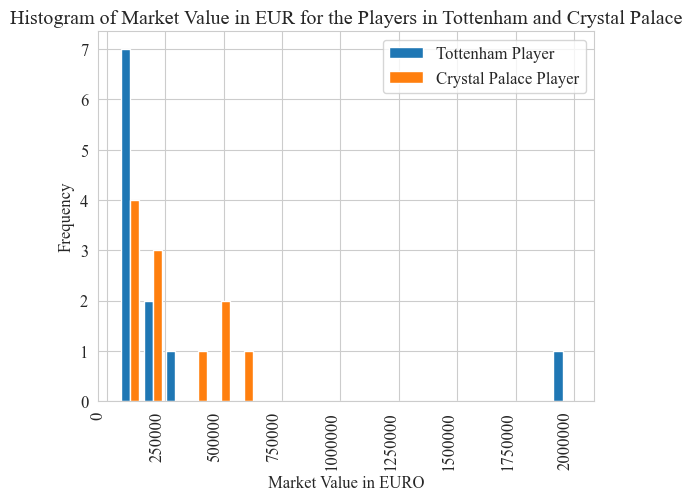

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Plotting the histogram
fig, ax = plt.subplots()
ax.hist((test[test['club_id'] == 148]['market_value_in_eur'].values, 
         test[test['club_id'] == 873]['market_value_in_eur'].values), 
        bins=20, # Adjust the number of bins as needed
        label=['Tottenham Player', 'Crystal Palace Player']) # Labels for the two datasets

# Setting the x-axis labels to show full values
ax.xaxis.set_major_formatter(FormatStrFormatter('%d')) # Format for integer values
plt.xticks(rotation=90, ha='right') # Rotation and alignment of labels
plt.xlabel('Market Value in EURO') # Label for the x-axis
plt.ylabel('Frequency') # Label for the y-axis
plt.legend() # Display the legend

ax.set_title('Histogram of Market Value in EUR for the Players in Tottenham and Crystal Palace')

plt.show()


In [24]:
game_events[game_events['game_id'] == 2350365]

,game_event_id,date,game_id,player_id,club_id,type,minute,description,player_in_id,player_assist_id
116444,a3d2aedcb04c9bb1fa1eecd6a7c57b8a,2013-08-18,2350365,12693,873,Substitutions,66,", Tactical",170322.0,NaN
116445,234d429da7799329d97017900c0f0f45,2013-08-18,2350365,19368,148,Substitutions,57,", Tactical",63494.0,NaN
116446,5668d1cc6729401a1320fa3b4cb414e6,2013-08-18,2350365,28336,873,Cards,90,"1. Yellow card , Foul",NaN,NaN
116447,ae3e98ffcc70ac676e92aac386a2a480,2013-08-18,2350365,33249,873,Substitutions,66,", Tactical",19085.0,NaN
116448,1eb41ffe6bf847da7eb01e232b388447,2013-08-18,2350365,34870,148,Goals,50,", Penalty, 1. Goal of the Season Assist: Handb...",NaN,77559.0
116449,47f133b2ce4f734cd95b41bc1879a28e,2013-08-18,2350365,34870,148,Substitutions,83,", Tactical",3875.0,NaN
116450,81ba7a29e94a4389e18180d2c63b42f6,2013-08-18,2350365,50174,148,Substitutions,86,", Tactical",27114.0,NaN
116451,88fa0b89ce4f225eb2f253c2ba67d6f2,2013-08-18,2350365,67202,873,Substitutions,66,", Tactical",3131.0,NaN


In [25]:
games.columns

Index(['game_id', 'competition_id', 'competition_type', 'season', 'round',
       'date', 'home_club_id', 'away_club_id', 'home_club_goals',
       'away_club_goals', 'aggregate', 'home_club_position',
       'away_club_position', 'home_club_name', 'away_club_name',
       'home_club_manager_name', 'away_club_manager_name',
       'home_club_formation', 'away_club_formation', 'stadium', 'attendance',
       'referee', 'url'],
      dtype='object')